In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
hbar = 1
electron_mass = 1
h = hbar * 2 * np.pi
displacement = -5
L = 20
num_points = 500
unit_length = 2*L/(num_points-1)
kinetic = hbar**2/(2*electron_mass*unit_length**2)
time_points = 10000
time = 10
unit_time = time/(time_points-1)

In [173]:
plots_dir = 'plots/'

In [174]:
x_grid = [-L + i*unit_length for i in range(num_points)]
x_grid = np.array(x_grid)

In [175]:
potentials = {}

def morse_well(x, dissoc_energy, morse_width, displacement):
    return dissoc_energy * (1 - np.exp(-morse_width * (x - displacement)))**2

d1 = 20
d2 = 20

m1 = 0.2
m2 = 0.2

dis1 = -15
dis2 = -13

shift = 8

morse1 = np.array([morse_well(x, d1, m1, dis1) for x in x_grid], dtype=np.float64)
morse2 = np.array([morse_well(x, d2, m2, dis2) for x in x_grid], dtype=np.float64)

morse2 = morse2 + shift

potentials['morse1'] = morse1
potentials['morse2'] = morse2



In [176]:
def get_hamiltonian(potential, num_points, unit_length, kinetic):
    hamiltonian = np.zeros((num_points, num_points))
    for i in range(num_points):
        hamiltonian[i, i] = 2*kinetic + potential[i]
    for i in range(num_points-1):
        hamiltonian[i, i+1] = -kinetic
        hamiltonian[i+1, i] = -kinetic
    return hamiltonian

def solve_tise(potential, num_points, unit_length, kinetic):
    hamiltonian = get_hamiltonian(potential, num_points, unit_length, kinetic)
    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian)

    idx_sorted = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx_sorted]
    eigenvectors = eigenvectors[:, idx_sorted]
    return eigenvalues, eigenvectors

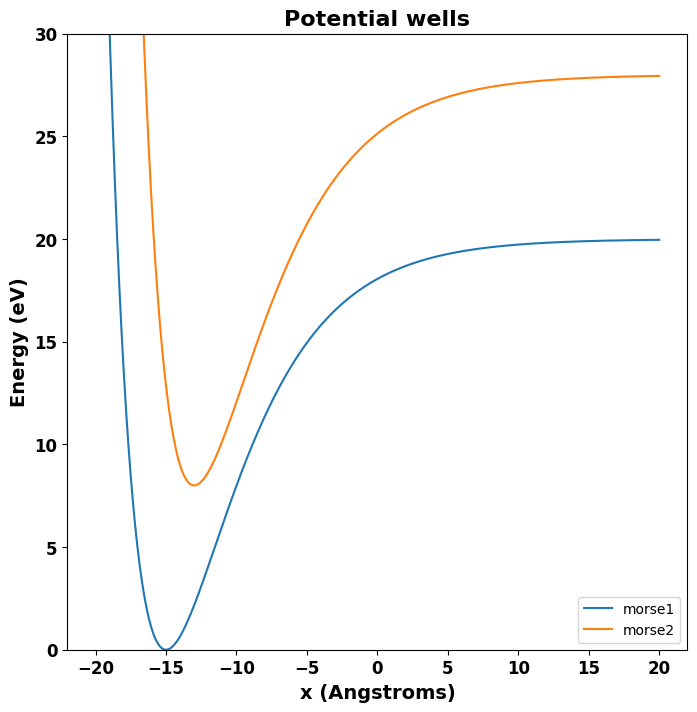

In [177]:
plt.figure(figsize=(8, 8))
plt.plot(x_grid, morse1, label='morse1')
plt.plot(x_grid, morse2, label='morse2')
plt.xlabel('x (Angstroms)', fontsize=14, fontweight='bold')
plt.ylabel('Energy (eV)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylim(0, 30)
plt.title('Potential wells', fontsize=16, fontweight='bold')
plt.legend()
plt.savefig(plots_dir + 'potential_wells.png', dpi=300, bbox_inches='tight')
plt.show()

In [178]:
eigenvalues1, eigenvectors1 = solve_tise(morse1, num_points, unit_length, kinetic)
eigenvalues2, eigenvectors2 = solve_tise(morse2, num_points, unit_length, kinetic)

idx_bound1 = np.where(eigenvalues1 < d1)[0]
idx_bound2 = np.where(eigenvalues2 < d2+shift)[0]

print('Number of bound states for morse1:', len(idx_bound1))
print('Number of bound states for morse2:', len(idx_bound2))


Number of bound states for morse1: 31
Number of bound states for morse2: 31


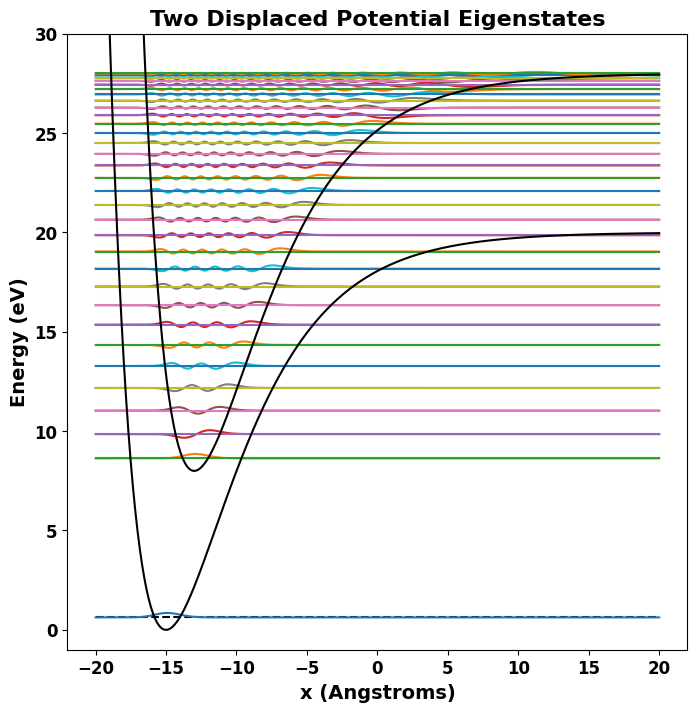

In [179]:
plt.figure(figsize=(8, 8))
plt.plot(x_grid, eigenvalues1[0] * np.ones_like(x_grid), "k--")
plt.plot(x_grid, eigenvalues1[0] + -eigenvectors1[:, 0])
for i in range(len(idx_bound2)):
    plt.plot(x_grid, eigenvalues2[i] + -eigenvectors2[:, i])
    plt.plot(x_grid, eigenvalues2[i] * np.ones_like(x_grid))
plt.plot(x_grid, morse1, label="Morse 1", color="black")
plt.plot(x_grid, morse2, label="Morse 2", color="black")
plt.xlabel("x (Angstroms)", fontsize=14, fontweight="bold")
plt.ylabel("Energy (eV)", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.title("Two Displaced Potential Eigenstates", fontsize=16, fontweight="bold")
plt.ylim(-1, 30)
plt.savefig(plots_dir + 'eigenstates.png', dpi=300, bbox_inches='tight')
plt.show()

In [180]:
fcs = np.zeros(num_points)
for i in range(num_points):
    fcs[i] = np.dot(eigenvectors1[:, 0], eigenvectors2[:, i]) **2

transition_energies = eigenvalues2 - eigenvalues1[0]

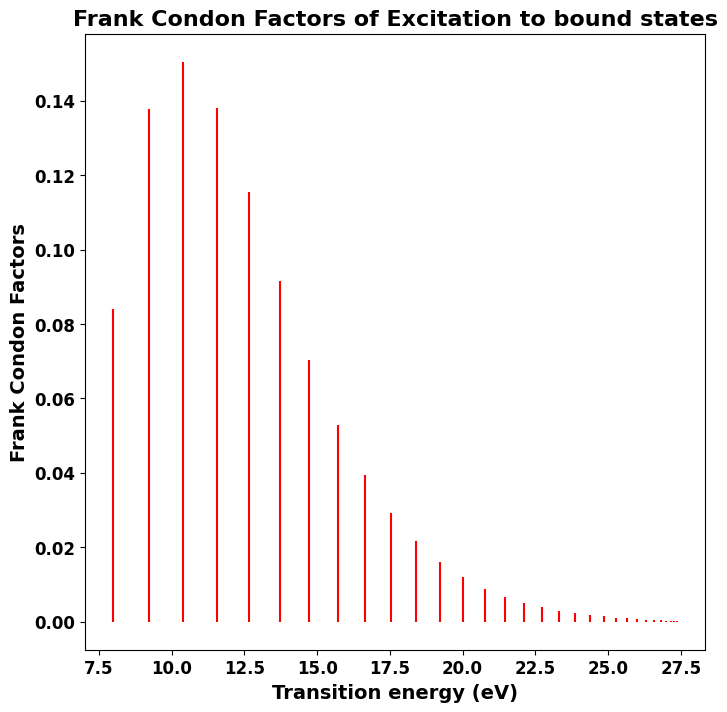

In [181]:
plt.figure(figsize=(8, 8))
plt.vlines(transition_energies[:len(idx_bound2)], 0, fcs[:len(idx_bound2)], color='red')
plt.xlabel('Transition energy (eV)', fontsize=14, fontweight='bold')
plt.ylabel('Frank Condon Factors', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Frank Condon Factors of Excitation to bound states', fontsize=16, fontweight='bold')
plt.savefig(plots_dir + 'fc_factor.png', dpi=300, bbox_inches='tight')
plt.show()



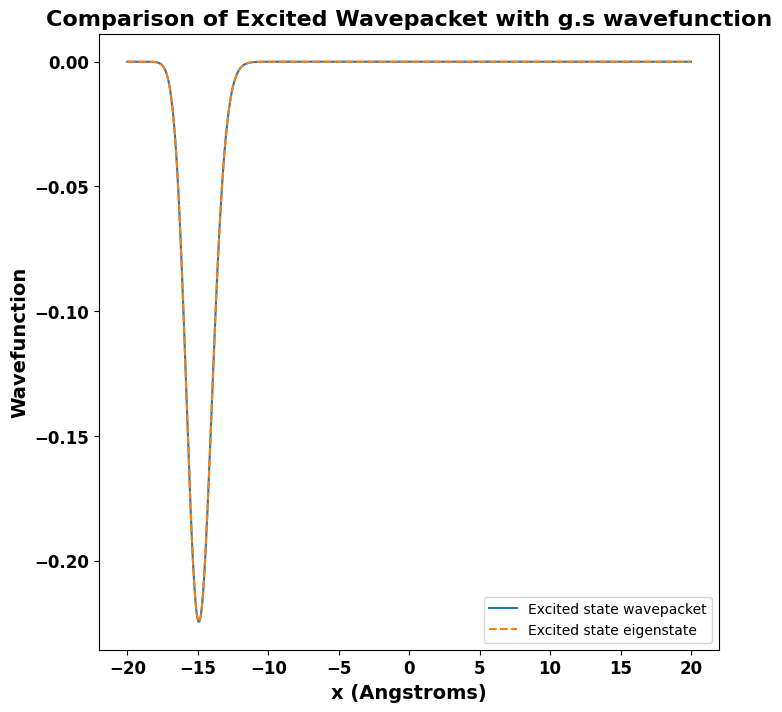

In [182]:
excited_state_wavepacket_0 = np.zeros(num_points)

for i in range(num_points):
    excited_state_wavepacket_0 += eigenvectors2[:, i] * np.dot(eigenvectors1[:, 0], eigenvectors2[:, i])

plt.figure(figsize=(8, 8))
plt.plot(x_grid, excited_state_wavepacket_0, label='Excited state wavepacket')
plt.plot(x_grid, eigenvectors1[:, 0], '--', label='Excited state eigenstate')
plt.xlabel('x (Angstroms)', fontsize=14, fontweight='bold')
plt.ylabel('Wavefunction', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Comparison of Excited Wavepacket with g.s wavefunction', fontsize=16, fontweight='bold')
plt.legend()
plt.savefig(plots_dir + 'excited_state_wavepacket.png', dpi=300, bbox_inches='tight')
plt.show()


In [183]:
psi_t = np.zeros((num_points, time_points), dtype=np.complex128)
psi_t[:, 0] = excited_state_wavepacket_0

for t in range(1, time_points):
    if t % 1000 == 0:
        print(t)

    temp_psi = np.zeros(num_points, dtype=np.complex128)
    for i in range(num_points):
        temp_psi += np.exp(-1j * eigenvalues2[i] * t * unit_time) * eigenvectors2[:, i] * np.dot(eigenvectors1[:, 0], eigenvectors2[:, i])
    psi_t[:, t] = temp_psi

1000
2000
3000
4000
5000
6000
7000
8000
9000


In [184]:
excited_wavepacket_time_evolution = np.zeros((num_points, time_points), dtype=np.complex128)

In [185]:

# coeffs = eigenvectors2.T @ eigenvectors1[:, 0]  # shape (num_points,)
# times = np.arange(time_points) * unit_time             # shape (1000,)
# phases = np.exp(-1j * np.outer(eigenvalues2, times))  # shape (num_points, 1000)

# psi_t = eigenvectors2 @ (coeffs[:, None] * phases)     # shape (num_points, 1000)


In [186]:
print(psi_t[:, 0][-10:])
print(excited_state_wavepacket_0[-10:])

[ 6.61644057e-18+0.j -1.21190054e-18+0.j  6.35307946e-18+0.j
 -2.28706623e-19+0.j -7.98803397e-18+0.j  2.69977492e-17+0.j
  3.16406239e-17+0.j -1.35163442e-17+0.j  1.01367871e-18+0.j
  1.94144013e-17+0.j]
[ 6.61644057e-18 -1.21190054e-18  6.35307946e-18 -2.28706623e-19
 -7.98803397e-18  2.69977492e-17  3.16406239e-17 -1.35163442e-17
  1.01367871e-18  1.94144013e-17]


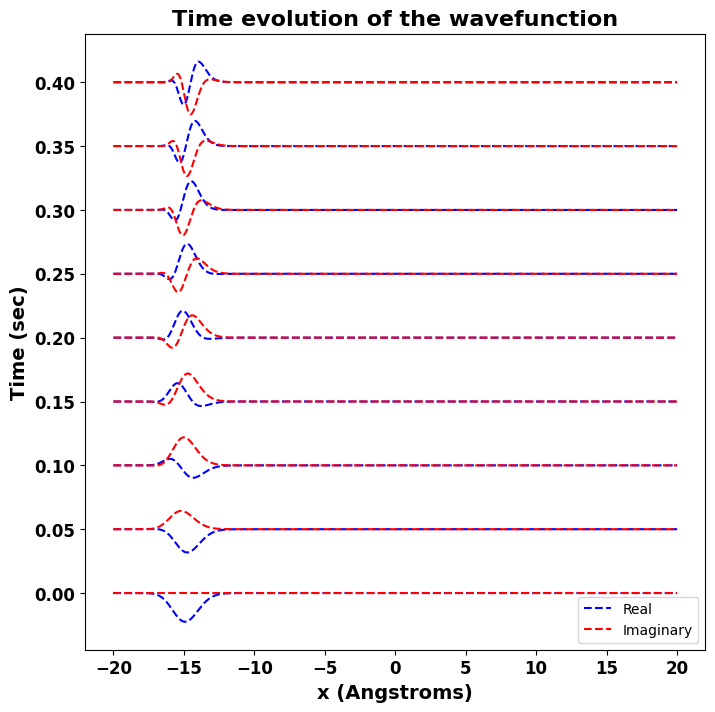

In [187]:
plt.figure(figsize=(8, 8))
times = [0, 50, 100, 150, 200, 250, 300, 350, 400]
for i in range(len(times)):
    if i == 0:
        plt.plot(x_grid, psi_t.real[:, times[i]] + 0.5*i, '--', color='blue', label='Real')
        plt.plot(x_grid, psi_t.imag[:, times[i]] + 0.5*i, '--', color='red', label='Imaginary')
    else:
        plt.plot(x_grid, psi_t.real[:, times[i]] + 0.5*i, '--', color='blue')
        plt.plot(x_grid, psi_t.imag[:, times[i]] + 0.5*i, '--', color='red')

ytick_positions = [0.5 * i for i in range(len(times))]
ytick_labels = [f"{(t)*unit_time:.2f}" for t in times]
plt.yticks(ytick_positions, ytick_labels)
plt.xlabel('x (Angstroms)', fontsize=14, fontweight='bold')
plt.ylabel('Time (sec)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Time evolution of the wavefunction', fontsize=16, fontweight='bold')

plt.legend()
plt.savefig(plots_dir + 'wavefunction_time_evolution.png', dpi=300, bbox_inches='tight')
plt.show()


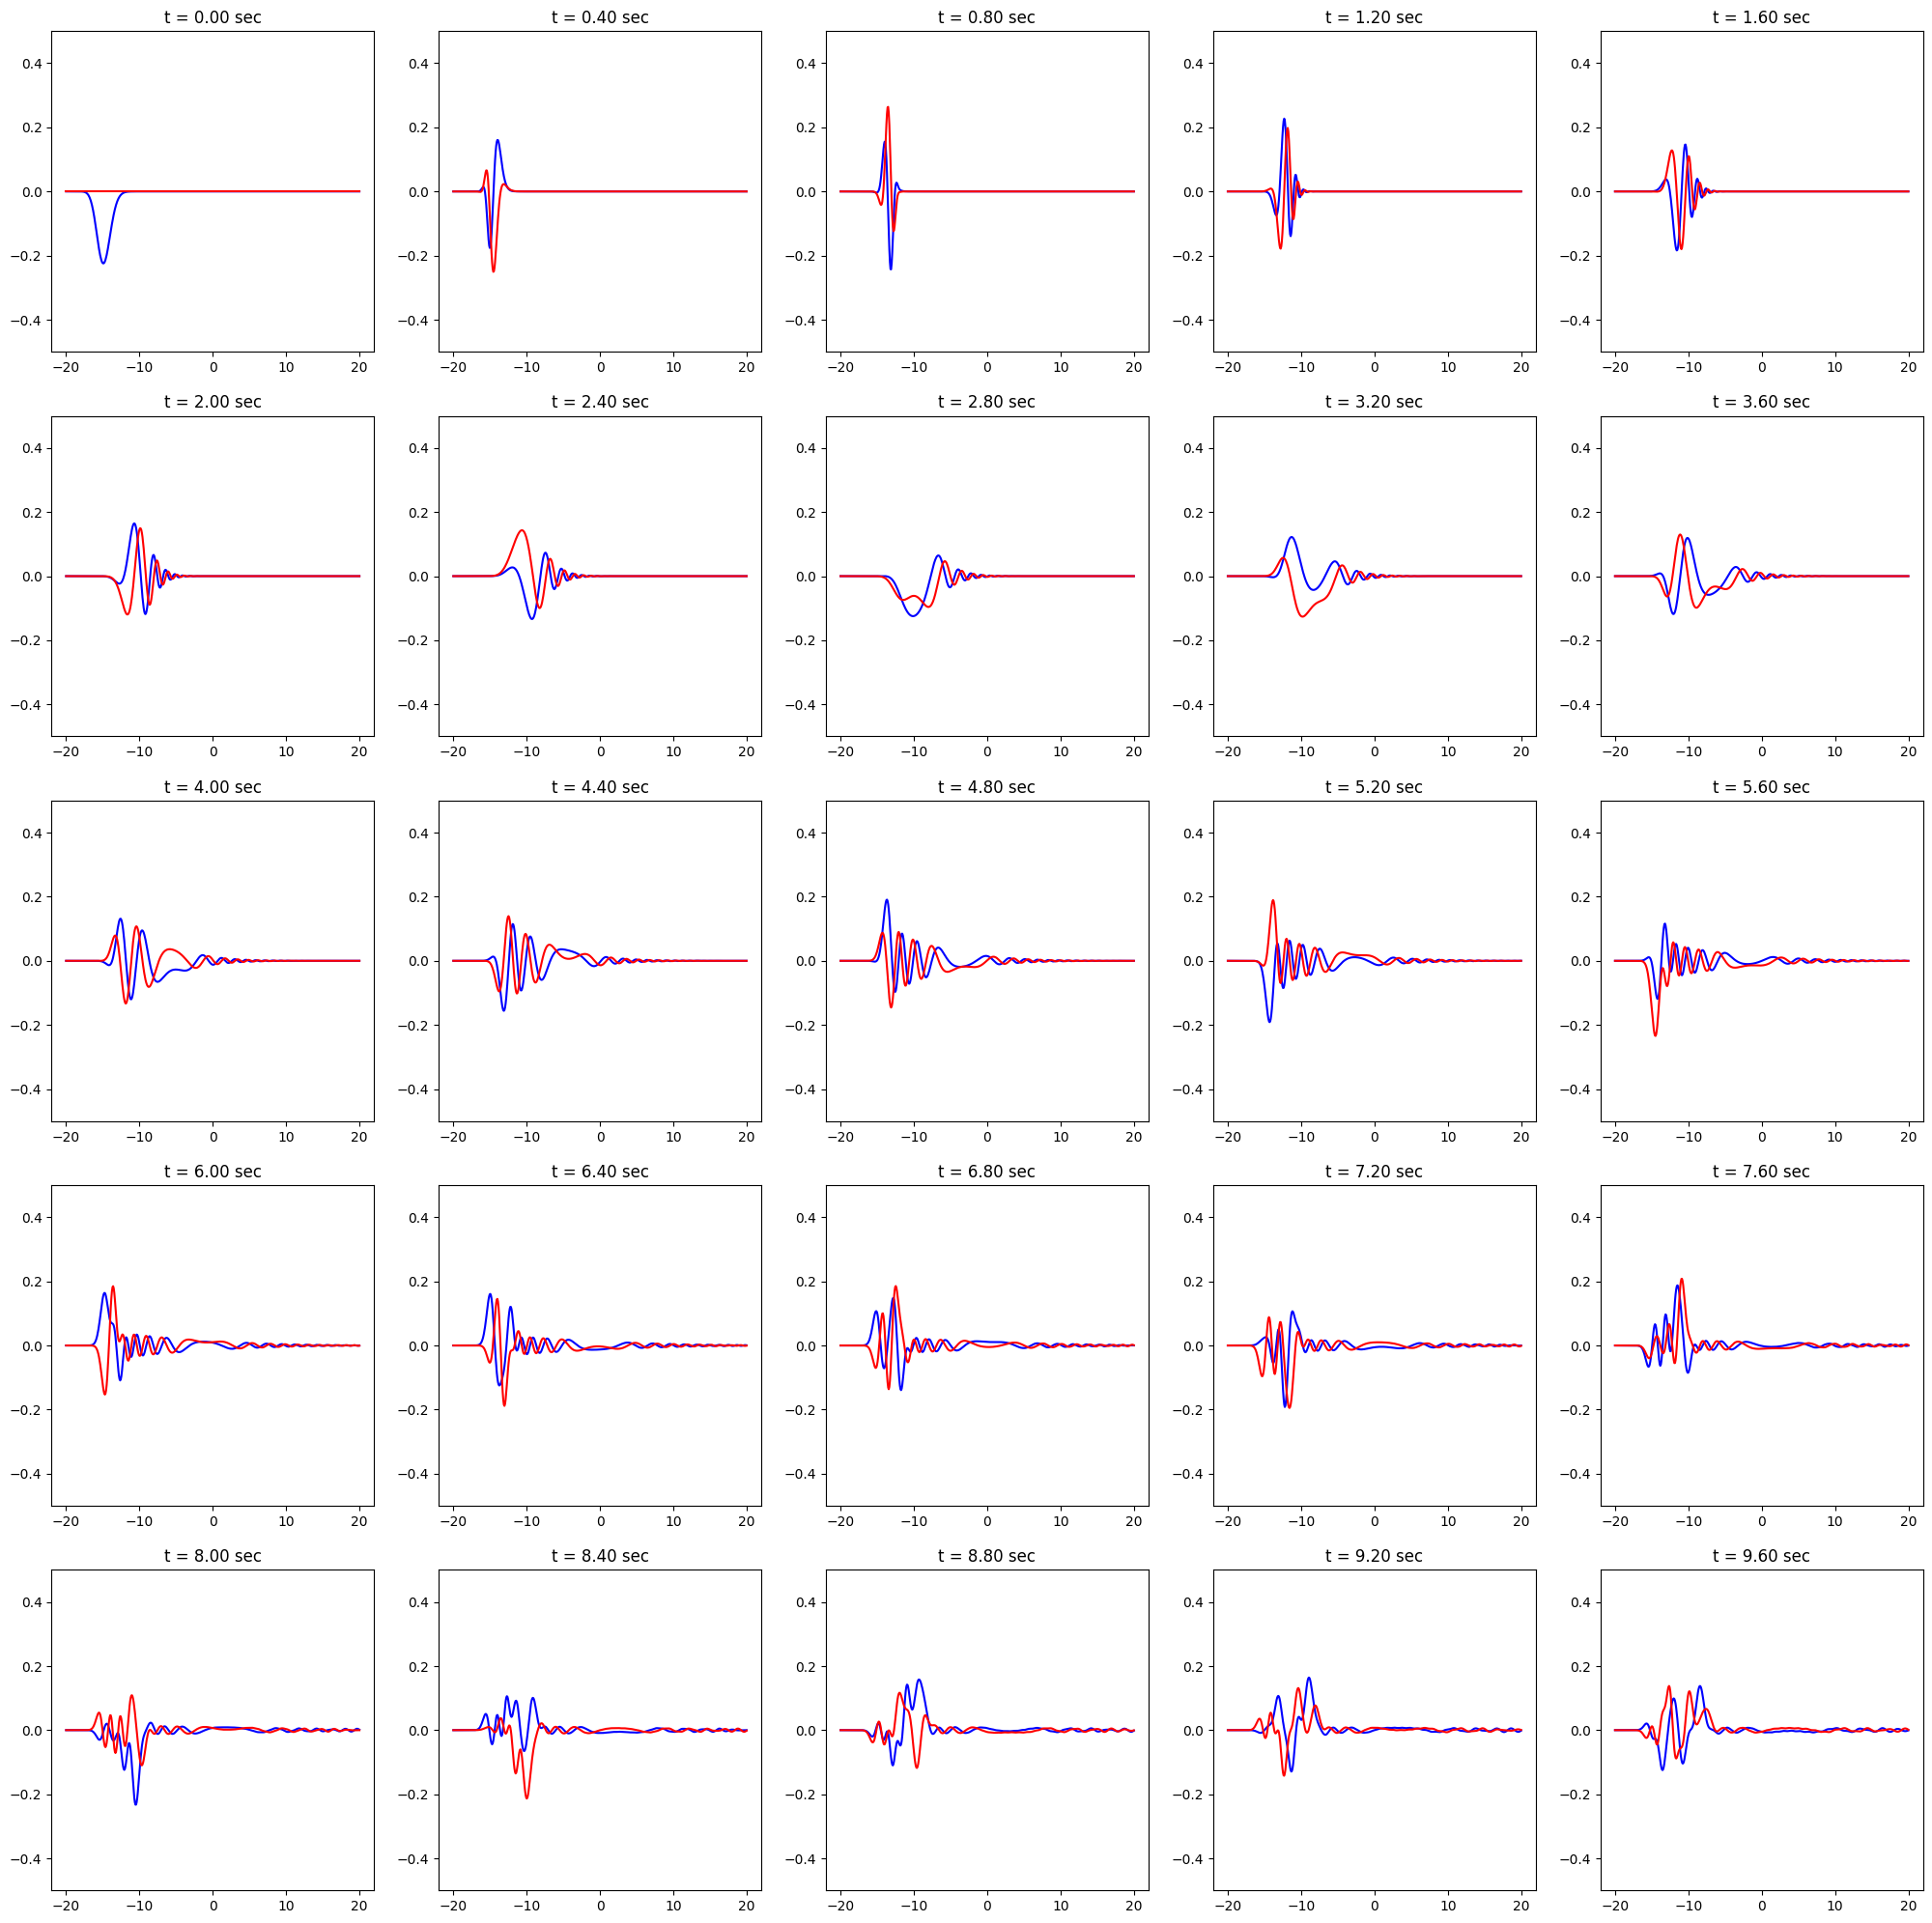

In [188]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))


for i in range(25):
    axs[i//5, i%5].plot(x_grid, psi_t.real[:, i*400], color='blue')
    axs[i//5, i%5].plot(x_grid, psi_t.imag[:, i*400], color='red')   
    axs[i//5, i%5].set_title(f't = {i*400*unit_time:.2f} sec')
    axs[i//5, i%5].set_ylim(-0.5, 0.5)

plt.show()



In [189]:
correlation_function = np.zeros(time_points)

for i in range(time_points):
    correlation_function[i] = np.vdot(excited_state_wavepacket_0, psi_t[:, i])

C:\Users\omkar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


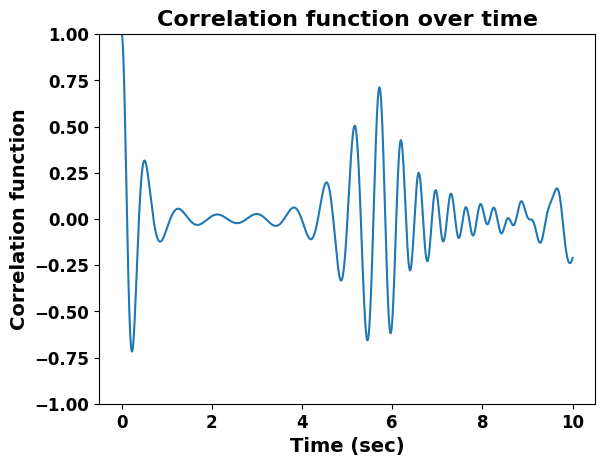

In [190]:
plt.plot(np.linspace(0, time, time_points), correlation_function)
plt.xlabel('Time (sec)', fontsize=14, fontweight='bold')
plt.ylabel('Correlation function', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Correlation function over time', fontsize=16, fontweight='bold')
plt.ylim(-1, 1)
plt.savefig(plots_dir + 'correlation_function.png', dpi=300, bbox_inches='tight')
plt.show()

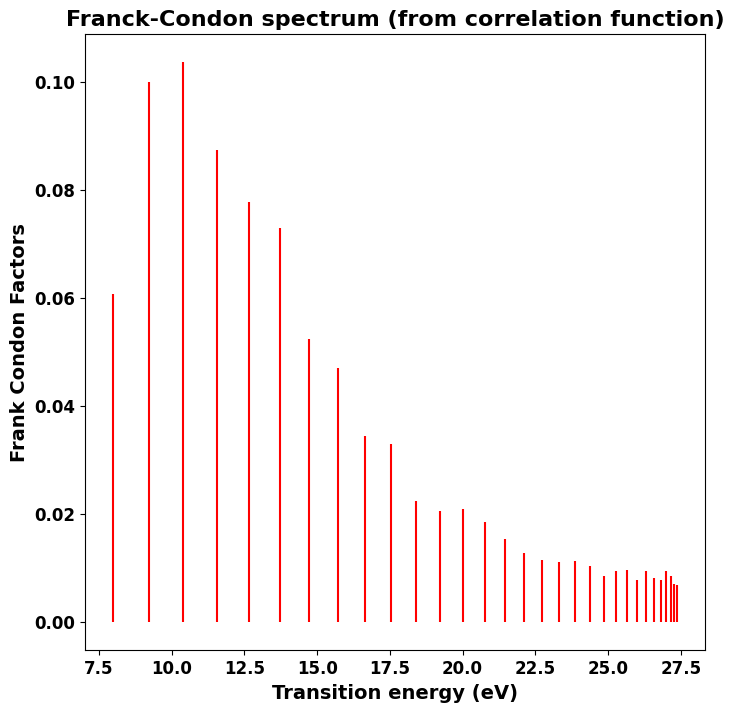

In [ ]:
time_array = np.arange(time_points) * unit_time
fc_amplitudes = []

for E in eigenvalues2[:len(idx_bound2)]:
    ft_val = np.sum(correlation_function * np.exp(1j * E * time_array)) * unit_time / (2 * np.pi)
    fc_amplitudes.append(np.abs(ft_val))

fc_amplitudes = np.array(fc_amplitudes)
transition_energies = eigenvalues2[:len(idx_bound2)] - eigenvalues1[0]

plt.figure(figsize=(8, 8))
plt.vlines(transition_energies, 0, fc_amplitudes, color='red')
plt.xlabel("Transition energy (eV)", fontsize=14, fontweight="bold")
plt.ylabel("Frank Condon Factors", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.title("Franck-Condon spectrum (from correlation function)", fontsize=16, fontweight="bold")
plt.savefig(plots_dir + 'fc_spectrum.png', dpi=300, bbox_inches='tight')
plt.show()


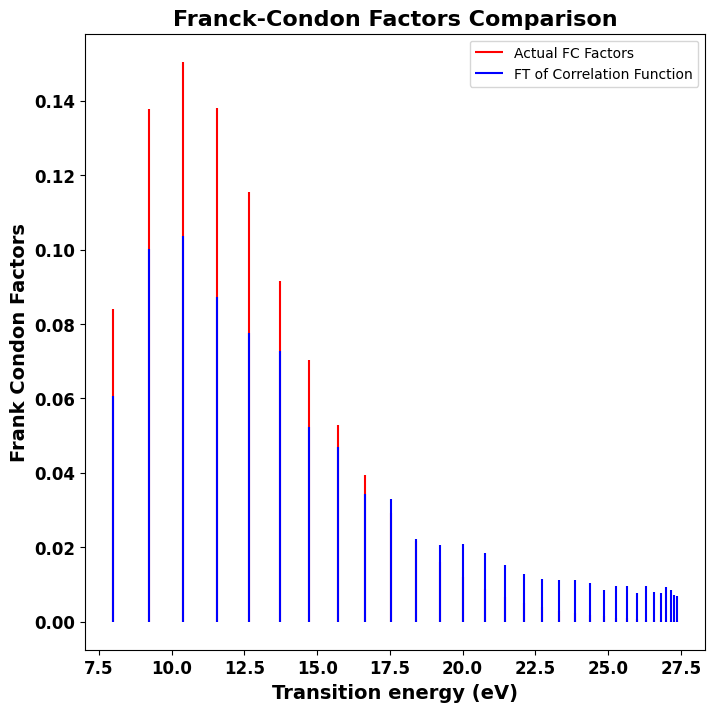

In [205]:
plt.figure(figsize=(8, 8))
plt.vlines(transition_energies, 0, fcs[:len(idx_bound2)], color='red', label='Actual FC Factors')
plt.vlines(transition_energies, 0, fc_amplitudes, color='blue', label='FT of Correlation Function')
plt.xlabel("Transition energy (eV)", fontsize=14, fontweight="bold")
plt.ylabel("Frank Condon Factors", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.title("Franck-Condon Factors Comparison", fontsize=16, fontweight="bold")
plt.legend()
plt.savefig(plots_dir + 'fc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [193]:
# time_points = 100000
# time = 1
# unit_time = time/(time_points-1)

# excited_wavepacket_time_evolution_real_fd = np.zeros((num_points, time_points))
# excited_wavepacket_time_evolution_imag_fd = np.zeros((num_points, time_points))

# excited_wavepacket_time_evolution_real_fd[:, 0] = excited_state_wavepacket_0
# excited_wavepacket_time_evolution_imag_fd[:, 0] = 0

# hamiltonian = get_hamiltonian(morse2, num_points, unit_length, kinetic)

# for i in range(time_points-1):
#     if i % 10000 == 0:
#         print(i)
    
#     excited_wavepacket_time_evolution_real_fd[:, i+1] = excited_wavepacket_time_evolution_real_fd[:, i] + (hamiltonian @ excited_wavepacket_time_evolution_imag_fd[:, i]) * unit_time
#     excited_wavepacket_time_evolution_imag_fd[:, i+1] = excited_wavepacket_time_evolution_imag_fd[:, i] - (hamiltonian @ excited_wavepacket_time_evolution_real_fd[:, i]) * unit_time

In [194]:
time_points = 10000
time = 10

unit_time = time/(time_points-1)

psi_t_fd = np.zeros((num_points, time_points), dtype=np.complex128)
psi_t_fd[:, 0] = psi_t[:, 0]

hamiltonian = get_hamiltonian(morse2, num_points, unit_length, kinetic)
hamiltonian = hamiltonian.astype(np.complex128)

for i in range(1, time_points):
    
    if i % 1000 == 0:
        print(i)
    psi_t_fd[:, i] = psi_t_fd[:, i-1] - 1j * unit_time * hamiltonian @ psi_t_fd[:, i-1]
    psi_t_fd[:, i] = psi_t_fd[:, i] / np.linalg.norm(psi_t_fd[:, i]) 





1000
2000
3000
4000
5000
6000
7000
8000
9000


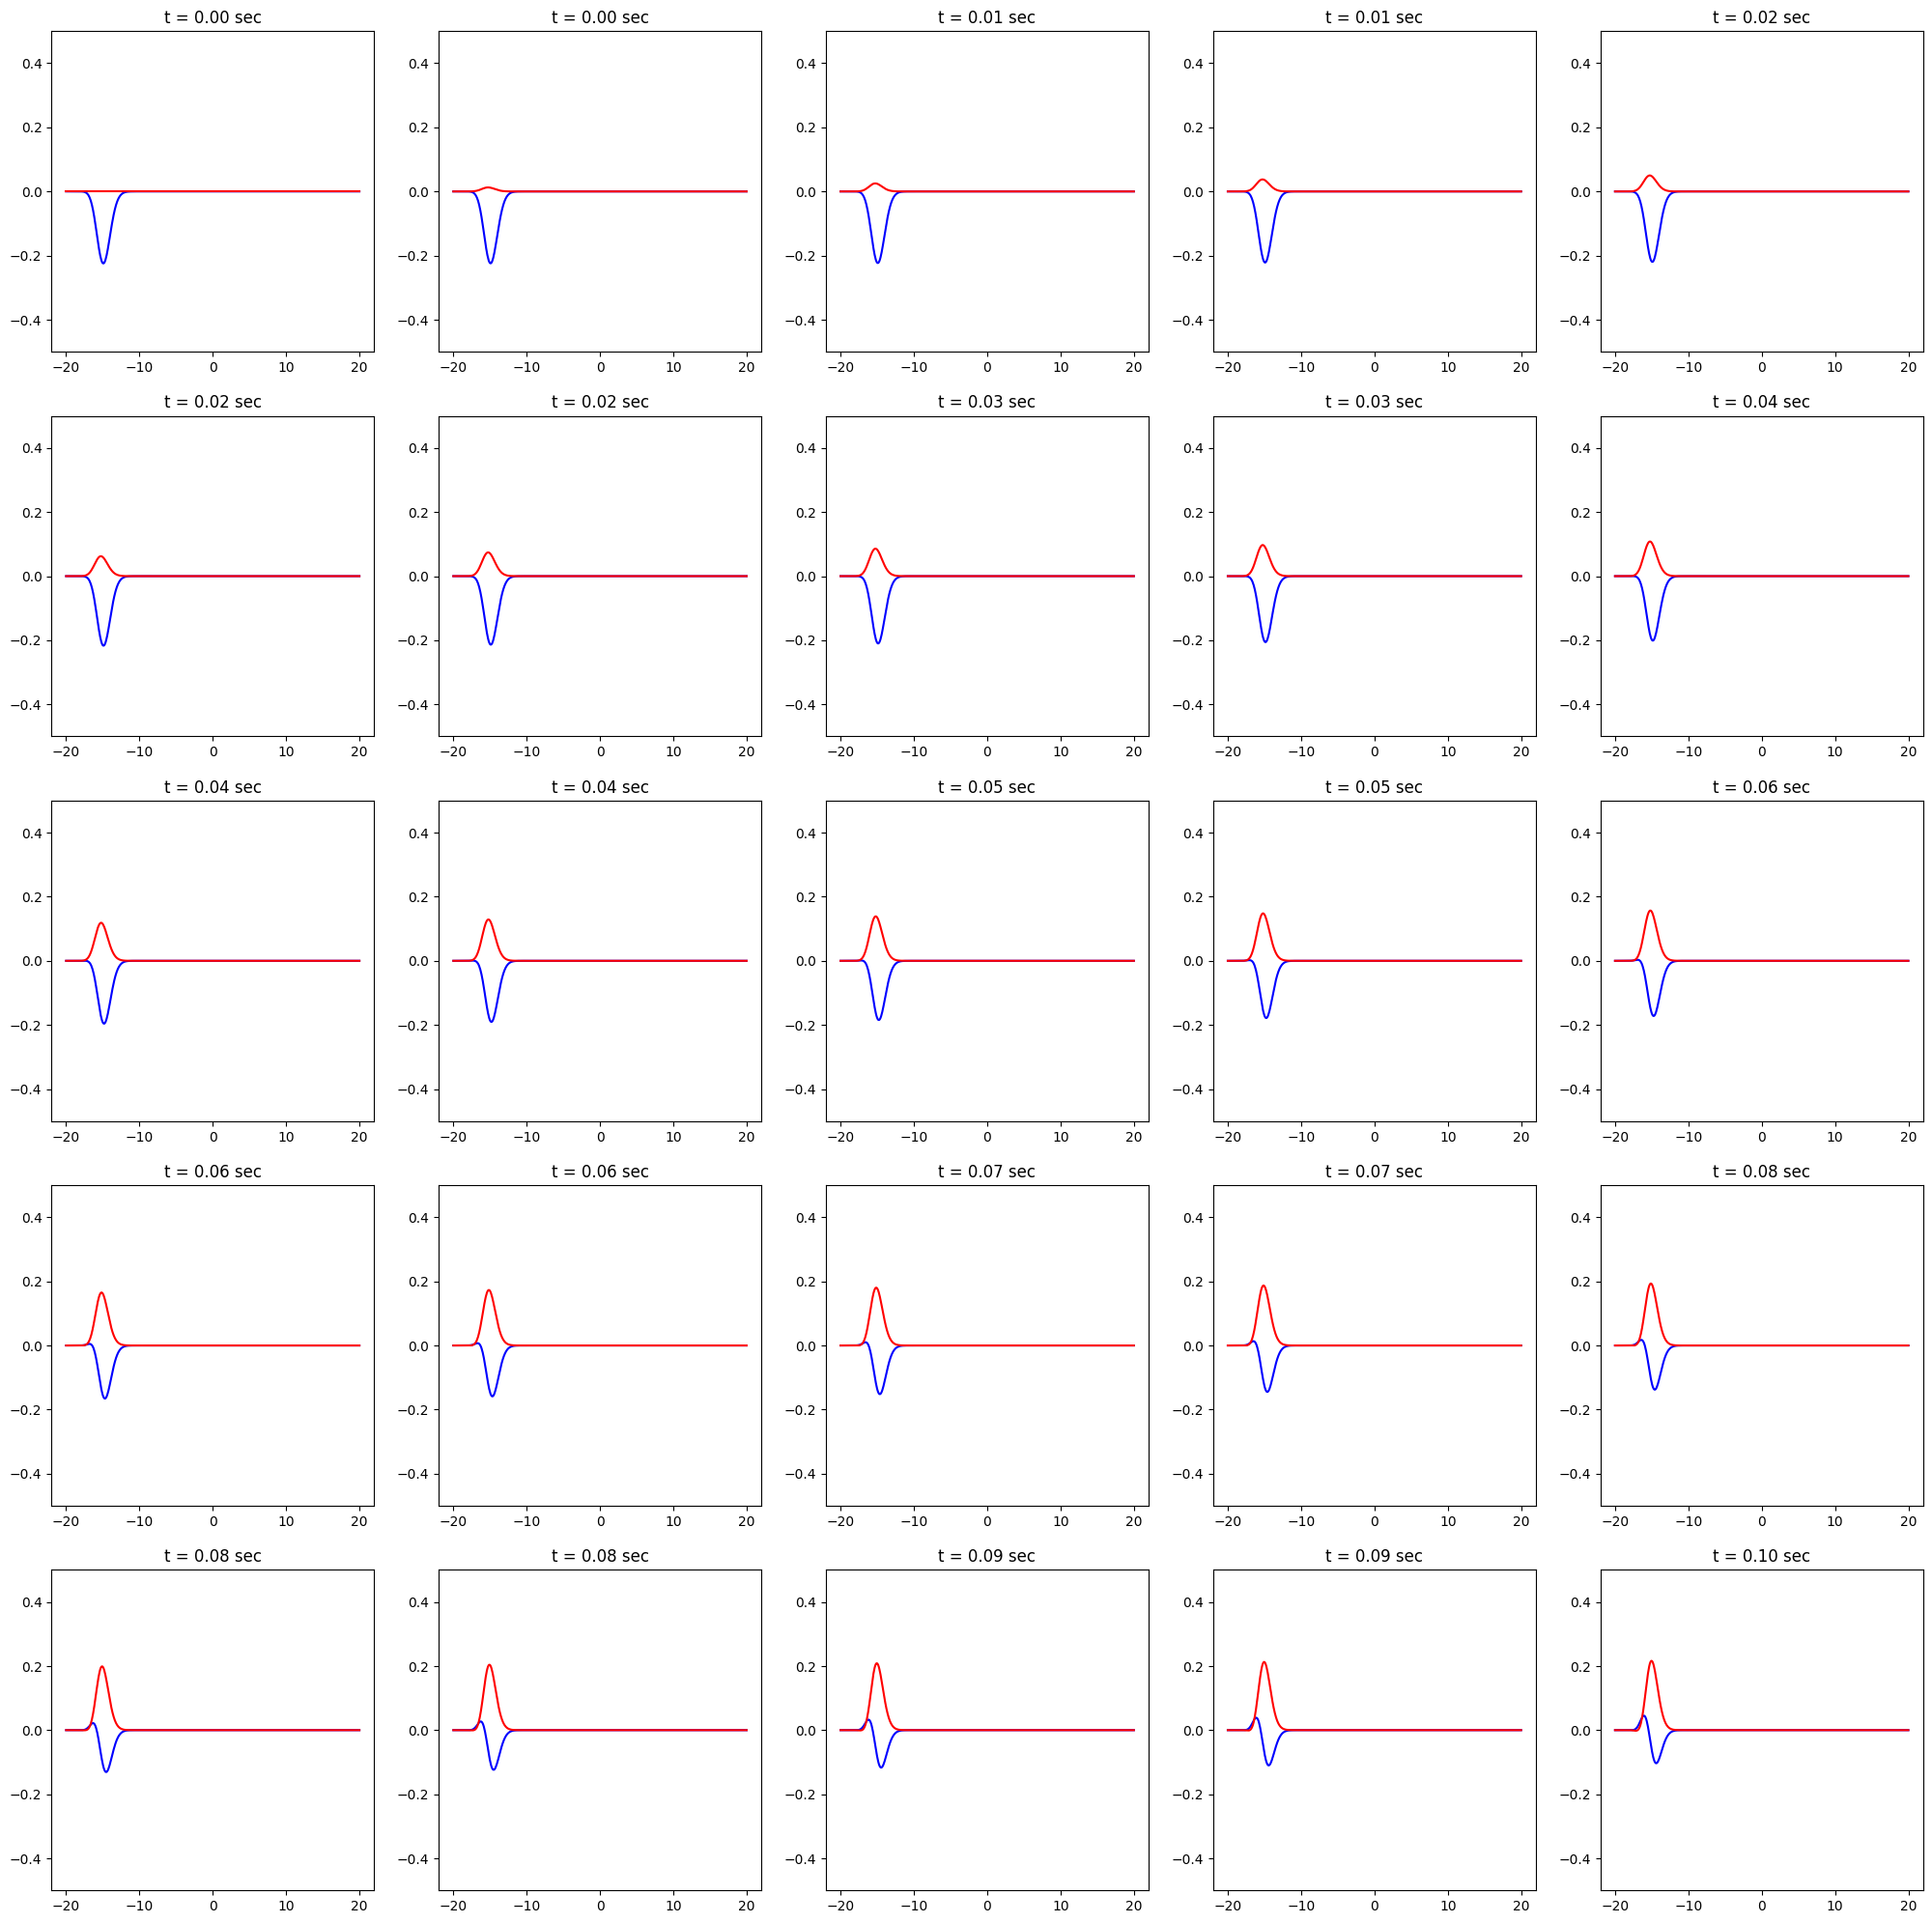

In [195]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))

for i in range(25):
    # axs[i//5, i%5].plot(x_grid, excited_wavepacket_time_evolution_real_fd[:, i*400], color='blue')
    # axs[i//5, i%5].plot(x_grid, excited_wavepacket_time_evolution_imag_fd[:, i*400], color='red')
    axs[i//5, i%5].plot(x_grid, psi_t_fd.real[:, i*4], color='blue')
    axs[i//5, i%5].plot(x_grid, psi_t_fd.imag[:, i*4], color='red')
    axs[i//5, i%5].set_title(f't = {i*4*unit_time:.2f} sec')
    axs[i//5, i%5].set_ylim(-0.5, 0.5)

plt.show()

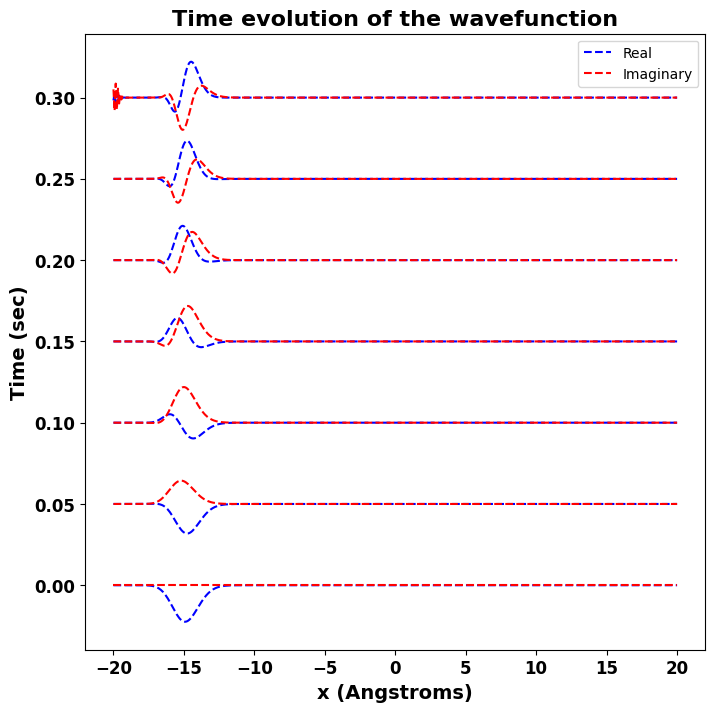

In [208]:
plt.figure(figsize=(8, 8))
times = [0, 50, 100, 150, 200, 250, 300]
for i in range(len(times)):
    if i == 0:
        plt.plot(x_grid, psi_t_fd.real[:, times[i]] + 0.5*i, '--', color='blue', label='Real')
        plt.plot(x_grid, psi_t_fd.imag[:, times[i]] + 0.5*i, '--', color='red', label='Imaginary')
    else:
        plt.plot(x_grid, psi_t_fd.real[:, times[i]] + 0.5*i, '--', color='blue')
        plt.plot(x_grid, psi_t_fd.imag[:, times[i]] + 0.5*i, '--', color='red')

ytick_positions = [0.5 * i for i in range(len(times))]
ytick_labels = [f"{(t)*unit_time:.2f}" for t in times]
plt.yticks(ytick_positions, ytick_labels)
plt.xlabel('x (Angstroms)', fontsize=14, fontweight='bold')
plt.ylabel('Time (sec)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Time evolution of the wavefunction', fontsize=16, fontweight='bold')

plt.legend()
plt.savefig(plots_dir + 'wavefunction_time_evolution_fd.png', dpi=300, bbox_inches='tight')
plt.show()

In [196]:
correlation_function_fd = np.zeros(time_points)

for i in range(time_points):
    correlation_function_fd[i] = np.vdot(excited_state_wavepacket_0, psi_t_fd[:, i])



C:\Users\omkar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


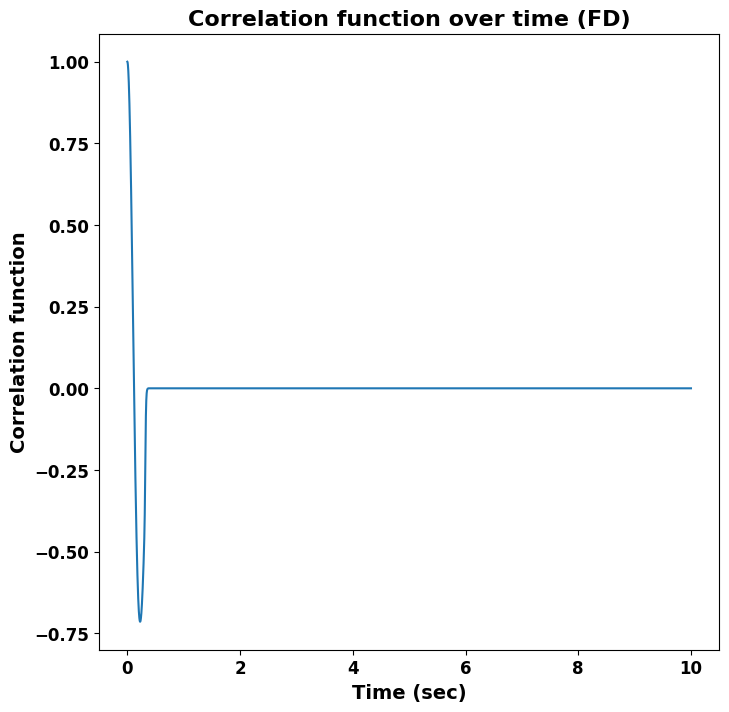

In [197]:
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, time, time_points), correlation_function_fd)
plt.xlabel('Time (sec)', fontsize=14, fontweight='bold')
plt.ylabel('Correlation function', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Correlation function over time (FD)', fontsize=16, fontweight='bold')
# plt.xlim(0, time_points)
# plt.ylim(-1, 1)
plt.savefig(plots_dir + 'correlation_function_fd.png', dpi=300, bbox_inches='tight')
plt.show()

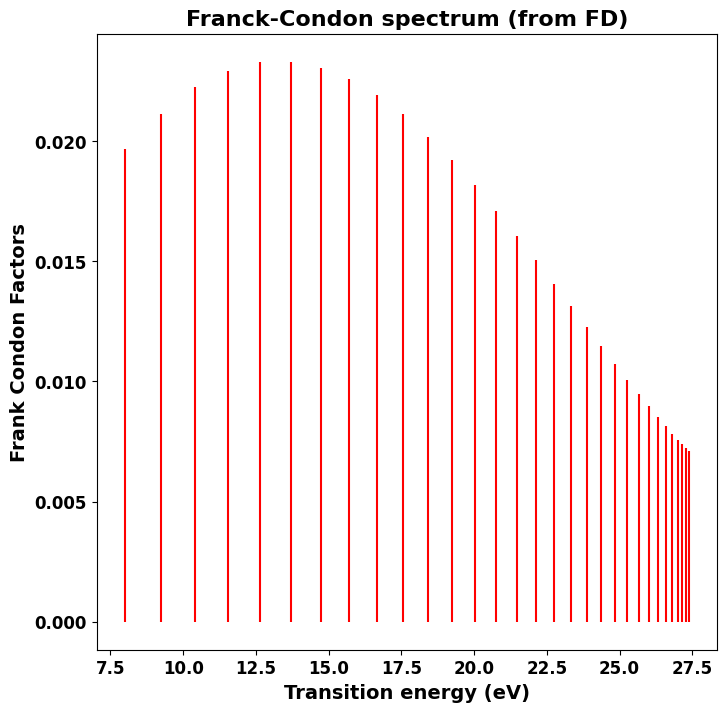

In [198]:
time_array = np.arange(time_points) * unit_time
fc_amplitudes = []

for E in eigenvalues2[:len(idx_bound2)]:
    ft_val = np.sum(correlation_function_fd * np.exp(1j * E * time_array)) * unit_time / (2 * np.pi)
    fc_amplitudes.append(np.abs(ft_val))

fc_amplitudes = np.array(fc_amplitudes)
# fc_intensities = fc_amplitudes**2
transition_energies = eigenvalues2[:len(idx_bound2)] - eigenvalues1[0]
plt.figure(figsize=(8, 8)) 
plt.vlines(transition_energies, 0, fc_amplitudes, color='red')
plt.xlabel("Transition energy (eV)", fontsize=14, fontweight='bold')
plt.ylabel("Frank Condon Factors", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Franck-Condon spectrum (from FD)", fontsize=16, fontweight='bold')
plt.savefig(plots_dir + 'fc_spectrum_fd.png', dpi=300, bbox_inches='tight')
plt.show()